Cyberbully Detection

In [1]:
import pandas as pd
import numpy as np

In [2]:
pip install deep-translator

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load the dataset
data = pd.read_csv('CyberBullyingTypesDataset.csv')

In [3]:
data.head()

,tweet_text,cyberbullying_type
0,Post-Cuomo push to toughen NY sexual harassmen...,Sexual Harassment
1,Push to toughen NY sexual harassment laws that...,Sexual Harassment
2,@GabbieHanna As if Trisha didn’t accuse him of...,Sexual Harassment
3,@fentsemadii True is that 🔥 thou I know nothin...,Sexual Harassment
4,Watch the recap video of the two-day hands-on ...,Sexual Harassment


In [4]:
data.shape

(2557, 2)

In [5]:
label_counts = data["cyberbullying_type"].value_counts()
label_counts

cyberbullying_type
Sexual Harassment    500
Slut Shaming         500
Doxing               441
Non-Cyberbullying    417
Revenge Porn         396
Cyberstalking        303
Name: count, dtype: int64

Data Augmentation Using Back Translation Method

In [6]:
from deep_translator import GoogleTranslator
from collections import Counter
import random
import time


# Check initial class distribution
print("Original class distribution:\n", data["cyberbullying_type"].value_counts())


# Back translation function (English → French → English)
def back_translate(text, src="en", mid="fr"):
    try:
        translated = GoogleTranslator(source=src, target=mid).translate(text)
        back_translated = GoogleTranslator(source=mid, target=src).translate(translated)
        return back_translated
    except Exception as e:
        print(f"Translation failed for: {text[:30]}... \nReason: {e}")
        return text  # fallback to original if fails


# Augment minority classes
def augment_minority_classes(
    data, label_col="cyberbullying_type", text_col="tweet_text", target_per_class=500
):
    augmented_rows = []
    class_counts = data[label_col].value_counts()

    for label, count in class_counts.items():
        if count < target_per_class:
            needed = target_per_class - count
            subset = data[data[label_col] == label]
            print(f"Augmenting class '{label}' by {needed} examples...")

            for i in range(needed):
                # Pick a random row from the class
                row = subset.sample(1).iloc[0]
                original_text = row[text_col]

                # Back translate
                augmented_text = back_translate(original_text)

                augmented_rows.append({text_col: augmented_text, label_col: label})

                # Add delay to avoid getting blocked by Google Translator
                time.sleep(1.2)  # slow but safe

    augmented_data = pd.DataFrame(augmented_rows)
    return pd.concat([data, augmented_data], ignore_index=True)


# Run augmentation
augmented_data = augment_minority_classes(data, target_per_class=500)

# New distribution
print("\nNew class distribution:\n", augmented_data["cyberbullying_type"].value_counts())

# Save the augmented dataset
augmented_data.to_csv("augmented_cyberbullying_dataset.csv", index=False)
print("\n✅ Augmented dataset saved as 'augmented_cyberbullying_dataset.csv'")

Original class distribution:
 cyberbullying_type
Sexual Harassment    500
Slut Shaming         500
Doxing               441
Non-Cyberbullying    417
Revenge Porn         396
Cyberstalking        303
Name: count, dtype: int64
Augmenting class 'Doxing' by 59 examples...
Augmenting class 'Non-Cyberbullying' by 83 examples...
Augmenting class 'Revenge Porn' by 104 examples...
Augmenting class 'Cyberstalking' by 197 examples...
Translation failed for: BIG story coming in the AM abo... 
Reason: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Translation failed for: DeSantis’ press secretary ente... 
Reason: DeSantis’ press secretary enters criminal plea deal for cyberstalking whistleblower @periclesukraine https://t.co/spuKuHAmT8 --> No translation was found using the current translator. Try another translator?
Translation failed for: @gina_scooter tumblr's lasting... 
Reason: ('Connection aborted.', RemoteDisconnected('Remote end closed connectio

In [7]:
data = pd.read_csv('augmented_cyberbullying_dataset.csv')

In [8]:
# Descriptive statistics for the 'label' column
label_stats = data["cyberbullying_type"].describe()
# Word count statistics for the 'message' column
data["word_count"] = data["tweet_text"].apply(lambda x: len(str(x).split()))
word_count_stats = data["word_count"].describe()


print(label_stats)
print(word_count_stats)

count                  3000
unique                    6
top       Sexual Harassment
freq                    500
Name: cyberbullying_type, dtype: object
count    3000.00000
mean       16.05300
std         6.20825
min         1.00000
25%        12.00000
50%        17.00000
75%        21.00000
max        31.00000
Name: word_count, dtype: float64


Traditional Machine Learning Models - Naive Bayes, SVM, Logistic Regression

Splitting

In [9]:
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Function to clean the tweet text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = text.lower().strip()  # Convert to lowercase and remove extra spaces
    return text


# Clean the tweet_text column
#data["cleaned_text"] = data["tweet_text"].apply(clean_text)
data["tweet_text"] = data["tweet_text"].fillna("")  # Replace NaN with an empty string
data["cleaned_text"] = data["tweet_text"].apply(clean_text)

# Encode labels (cyberbullying_type)
label_encoder = LabelEncoder()
data["label"] = label_encoder.fit_transform(data["cyberbullying_type"])

# Split the dataset into train and test sets
X = data["cleaned_text"]
y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check the cleaned and encoded dataset
data[["cleaned_text", "label"]].head(), X_train.shape, X_test.shape

(                                        cleaned_text  label
 0  postcuomo push to toughen ny sexual harassment...      4
 1  push to toughen ny sexual harassment laws that...      4
 2  as if trisha didnt accuse him of sexual harass...      4
 3  true is that  thou i know nothing about the se...      4
 4  watch the recap video of the twoday handson ex...      4,
 (2400,),
 (600,))

Support Vector Machine 

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Convert text data into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train the SVM classifier
svm_classifier = SVC(kernel="linear", probability=True, random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)

# Get probability scores for the positive class
svm_probs = svm_classifier.predict_proba(X_test_tfidf)[:, 1]  # 1 for positive class

# Predict and evaluate the SVM model
svm_predictions = svm_classifier.predict(X_test_tfidf)
svm_report = classification_report(
    y_test, svm_predictions, target_names=label_encoder.classes_
)

svm_report

'                   precision    recall  f1-score   support\n\n    Cyberstalking       0.81      0.82      0.82        95\n           Doxing       0.83      0.78      0.80        99\nNon-Cyberbullying       0.60      0.91      0.73        94\n     Revenge Porn       0.91      0.79      0.85       101\nSexual Harassment       0.95      0.81      0.87       118\n     Slut Shaming       0.91      0.78      0.84        93\n\n         accuracy                           0.81       600\n        macro avg       0.84      0.82      0.82       600\n     weighted avg       0.84      0.81      0.82       600\n'

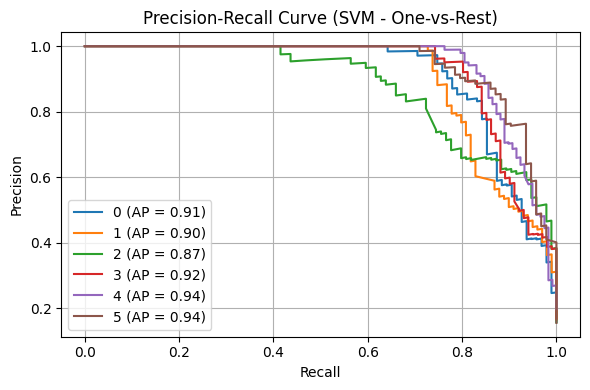

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=svm_classifier.classes_)
svm_probs = svm_classifier.predict_proba(X_test_tfidf)

# Plot PR curve for each class
plt.figure(figsize=(6, 4))

for i, class_label in enumerate(svm_classifier.classes_):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], svm_probs[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], svm_probs[:, i])
    plt.plot(recall, precision, label=f"{class_label} (AP = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (SVM - One-vs-Rest)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

Naive Bayes Model

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
nb_predictions = nb_classifier.predict(X_test_tfidf)
nb_report = classification_report(
    y_test, nb_predictions, target_names=label_encoder.classes_
)

nb_report

'                   precision    recall  f1-score   support\n\n    Cyberstalking       0.88      0.74      0.80        95\n           Doxing       0.76      0.75      0.75        99\nNon-Cyberbullying       0.77      0.76      0.76        94\n     Revenge Porn       0.80      0.83      0.82       101\nSexual Harassment       0.93      0.82      0.87       118\n     Slut Shaming       0.73      0.95      0.82        93\n\n         accuracy                           0.81       600\n        macro avg       0.81      0.81      0.80       600\n     weighted avg       0.81      0.81      0.81       600\n'

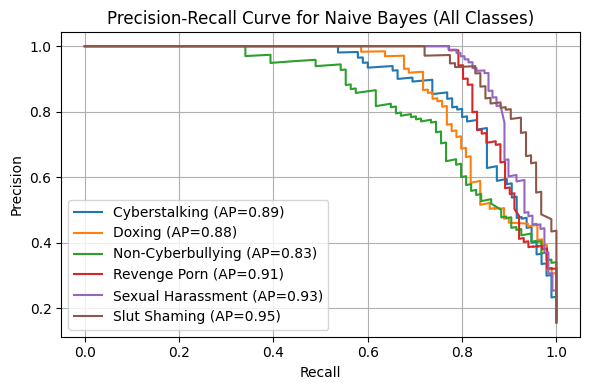

In [13]:
# Get predicted probabilities
nb_probs = nb_classifier.predict_proba(X_test_tfidf)

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=nb_classifier.classes_)

# Create the plot
plt.figure(figsize=(6, 4))

# Plot PR curve for each class
for i, class_label in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], nb_probs[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], nb_probs[:, i])
    plt.plot(recall, precision, label=f"{class_label} (AP={avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Naive Bayes (All Classes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Logistic Regression Classifier

In [14]:
# Train the Logistic Regression classifier
logreg_classifier = LogisticRegression(max_iter=1000, random_state=42)
logreg_classifier.fit(X_train_tfidf, y_train)
logreg_predictions = logreg_classifier.predict(X_test_tfidf)
logreg_report = classification_report(
    y_test, logreg_predictions, target_names=label_encoder.classes_
)

logreg_report

'                   precision    recall  f1-score   support\n\n    Cyberstalking       0.81      0.80      0.80        95\n           Doxing       0.81      0.78      0.79        99\nNon-Cyberbullying       0.59      0.88      0.71        94\n     Revenge Porn       0.91      0.79      0.85       101\nSexual Harassment       0.97      0.83      0.89       118\n     Slut Shaming       0.98      0.86      0.91        93\n\n         accuracy                           0.82       600\n        macro avg       0.84      0.82      0.83       600\n     weighted avg       0.85      0.82      0.83       600\n'

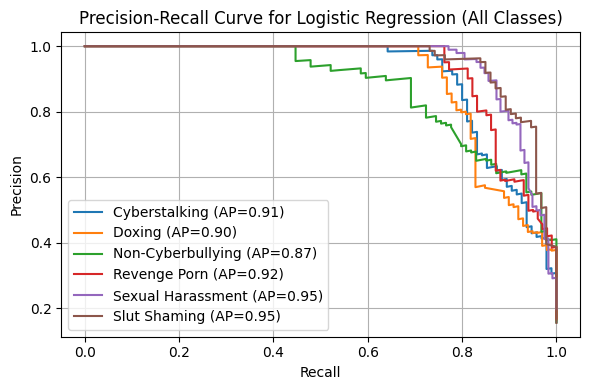

In [15]:
# Get predicted probabilities
logreg_probs = logreg_classifier.predict_proba(X_test_tfidf)

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=logreg_classifier.classes_)

# Create the plot
plt.figure(figsize=(6, 4))

# Plot PR curve for each class
for i, class_label in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], logreg_probs[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], logreg_probs[:, i])
    plt.plot(recall, precision, label=f"{class_label} (AP={avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Logistic Regression (All Classes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SVM Accuracy: 0.81
Naive Bayes Accuracy: 0.81
Logistic Regression Accuracy: 0.82


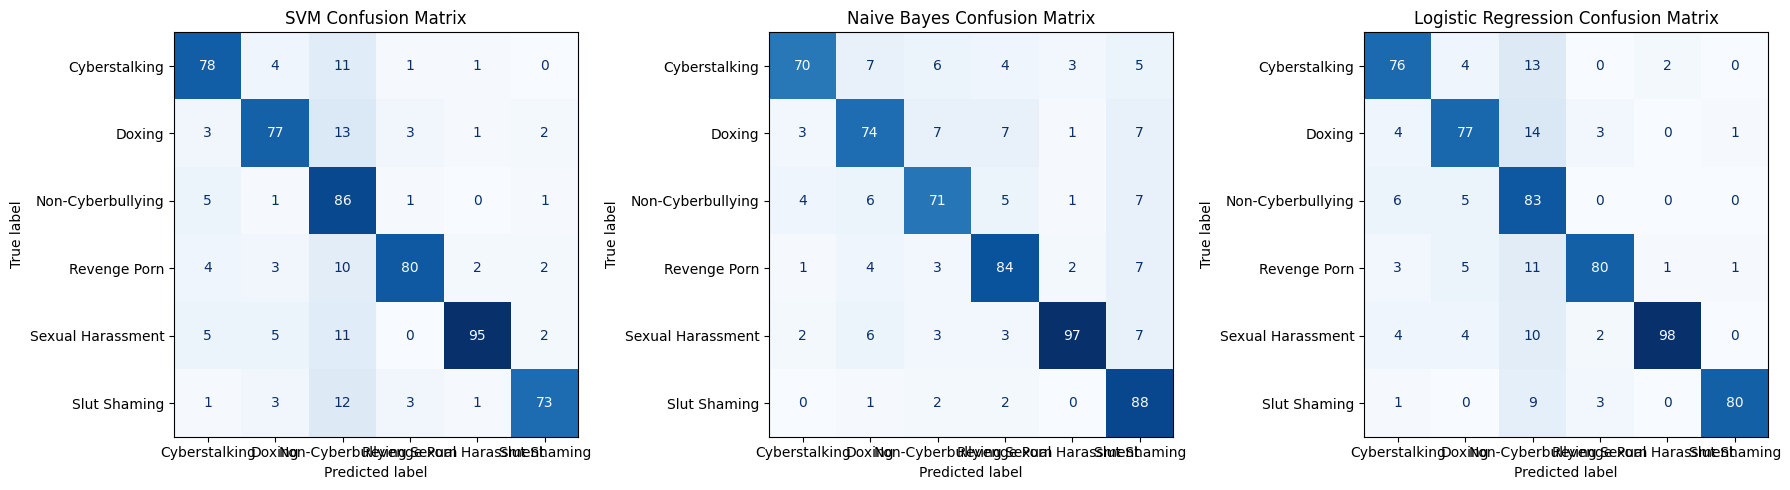

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Calculate confusion matrices and accuracies
models = {
    "SVM": (svm_predictions, "SVM"),
    "Naive Bayes": (nb_predictions, "Naive Bayes"),
    "Logistic Regression": (logreg_predictions, "Logistic Regression"),
}

plt.figure(figsize=(18, 5))
for i, (model_name, (predictions, title)) in enumerate(models.items(), 1):
    cm = confusion_matrix(y_test, predictions)
    acc = accuracy_score(y_test, predictions)
    print(f"{model_name} Accuracy: {acc:.2f}")

    # Plot the confusion matrix
    plt.subplot(1, 3, i)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=label_encoder.classes_
    )
    disp.plot(ax=plt.gca(), cmap="Blues", colorbar=False)
    plt.title(f"{title} Confusion Matrix")

plt.tight_layout()
plt.show()

LSTM Model

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Tokenize the text
max_words = 5000  # Vocabulary size
max_len = 100  # Max length of sequences

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure equal length
X_train_padded = pad_sequences(
    X_train_seq, maxlen=max_len, padding="post", truncating="post"
)
X_test_padded = pad_sequences(
    X_test_seq, maxlen=max_len, padding="post", truncating="post"
)

# Build the LSTM model
lstm_model = Sequential(
    [
        Embedding(max_words, 128, input_length=max_len),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dense(32, activation="relu"),
        Dense(len(label_encoder.classes_), activation="softmax"),
    ]
)

lstm_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

c:\Users\srishti\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.1600 - loss: 1.7947 - val_accuracy: 0.1567 - val_loss: 1.7949
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.1732 - loss: 1.7943 - val_accuracy: 0.1550 - val_loss: 1.7927
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.1581 - loss: 1.7927 - val_accuracy: 0.1550 - val_loss: 1.7942
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.1779 - loss: 1.7922 - val_accuracy: 0.1583 - val_loss: 1.7940
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.1640 - loss: 1.7921 - val_accuracy: 0.1650 - val_loss: 1.7924
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.1760 - loss: 1.7922 - val_accuracy: 0.1583 - val_loss: 1.7941
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1595 - loss: 1.7914 - val_accuracy: 0.1567 - val_loss: 1.7929
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.1655 - loss: 1.7918 - val_accuracy: 0.1567 - 

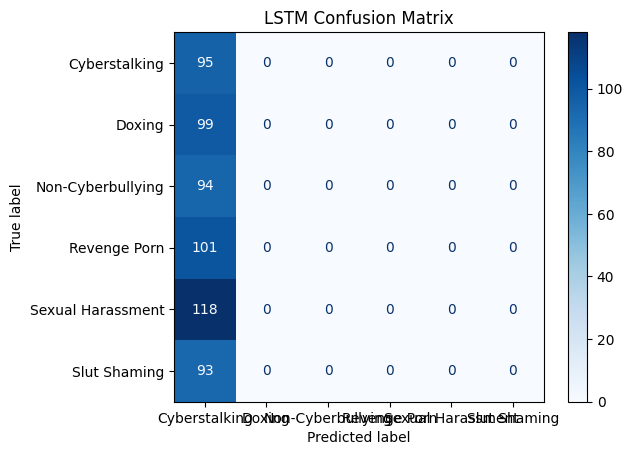

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train the LSTM model
history = lstm_model.fit(
    X_train_padded,
    y_train,
    validation_data=(X_test_padded, y_test),
    epochs=20,
    batch_size=32,
)

# Predict classes
lstm_predictions = lstm_model.predict(X_test_padded)
lstm_pred_classes = lstm_predictions.argmax(axis=1)

# Calculate accuracy
lstm_accuracy = accuracy_score(y_test, lstm_pred_classes)
print(f"LSTM Accuracy: {lstm_accuracy:.2f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, lstm_pred_classes)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=label_encoder.classes_
)
disp.plot(cmap="Blues")
plt.title("LSTM Confusion Matrix")
plt.show()

In [21]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Convert y_train and y_test to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Check if labels are one-hot encoded (i.e., shape (samples, classes))
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    print("One-hot detected, converting to categorical labels...")
    y_train = np.argmax(y_train, axis=1)  # Convert one-hot to class labels
    y_test = np.argmax(y_test, axis=1)

# Check unique classes before encoding
print("Unique labels before encoding:", np.unique(y_train))

# Apply Label Encoding only if labels are strings
if y_train.dtype.type is np.str_ or y_train.dtype.type is np.object_:
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    print("Applied Label Encoding.")

# Final check
print("Unique labels after encoding:", np.unique(y_train))

Unique labels before encoding: [0 1 2 3 4 5]
Unique labels after encoding: [0 1 2 3 4 5]


Bi-LSTM Model (Optimized Using Adam)

In [46]:

# --- Build Bi-LSTM Model ---
bi_lstm_model = Sequential(
    [
        Embedding(input_dim=max_words, output_dim=128),
        Bidirectional(LSTM(64, return_sequences=True)),  # Bi-LSTM layer
        Dropout(0.2),
        Bidirectional(LSTM(32)),  # Another Bi-LSTM layer
        Dense(32, activation="relu"),
        Dense(
            len(label_encoder.classes_), activation="softmax"
        ),  # Multi-class classification
    ]
)

# Compile Model
bi_lstm_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# --- Train Model ---
history = bi_lstm_model.fit(
    X_train_padded.astype(np.float32),
    y_train,
    validation_data=(X_test_padded.astype(np.float32), y_test),
    epochs=25,
    batch_size=16,
)

# --- Evaluate Model ---
bi_lstm_predictions = bi_lstm_model.predict(X_test_padded)

Epoch 1/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.2724 - loss: 1.6468 - val_accuracy: 0.6233 - val_loss: 1.0125
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.8088 - loss: 0.6555 - val_accuracy: 0.7850 - val_loss: 0.6792
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9375 - loss: 0.2359 - val_accuracy: 0.8083 - val_loss: 0.6348
Epoch 4/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9668 - loss: 0.1362 - val_accuracy: 0.7983 - val_loss: 0.7943
Epoch 5/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9780 - loss: 0.0864 - val_accuracy: 0.8133 - val_loss: 0.8072
Epoch 6/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9818 - loss: 0.0724 - val_accuracy: 0.7850 - val_loss: 0.8710
Epoch 7/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9851 - loss: 0.0560 - val_accuracy: 0.7833 - val_loss: 1.0743
Epoch 8/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9776 - loss: 0.0524 - val_acc

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Test Accuracy: 0.8200

Classification Report:
                    precision    recall  f1-score   support

    Cyberstalking       0.85      0.83      0.84        95
           Doxing       0.73      0.85      0.79        99
Non-Cyberbullying       0.64      0.86      0.73        94
     Revenge Porn       0.92      0.77      0.84       101
Sexual Harassment       0.97      0.79      0.87       118
     Slut Shaming       0.92      0.83      0.87        93

         accuracy                           0.82       600
        macro avg       0.84      0.82      0.82       600
     weighted avg       0.84      0.82      0.82       600



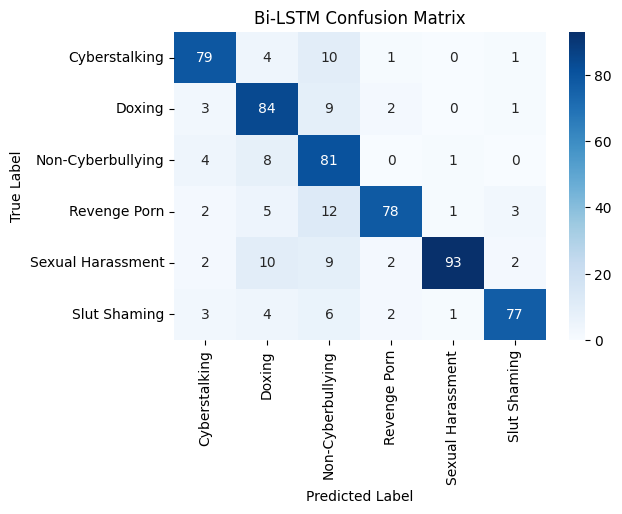

In [47]:
import seaborn as sns
#Predictions
y_pred_probs = bi_lstm_model.predict(X_test_padded)  # Get probability predictions
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

#Compute Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

#Ensure target_names is a list
target_names = list(map(str, label_encoder.classes_))  # Convert to string list

# Classification Report 
print("\nClassification Report:\n",classification_report(y_test, y_pred, target_names=target_names),)

#Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Bi-LSTM Confusion Matrix")
plt.show()

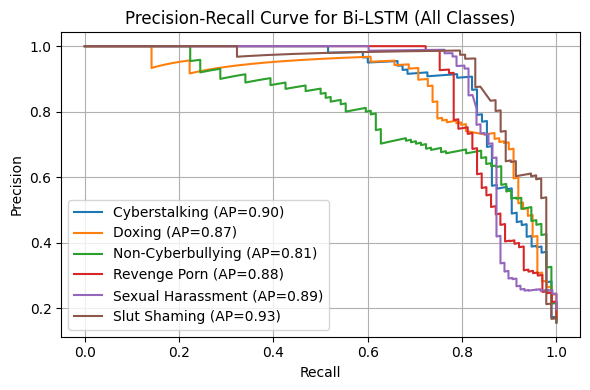

In [48]:
# Binarize true labels
y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))

# Create the plot
plt.figure(figsize=(6, 4))

# Plot PR curve for each class
for i, class_label in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f"{class_label} (AP={avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Bi-LSTM (All Classes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

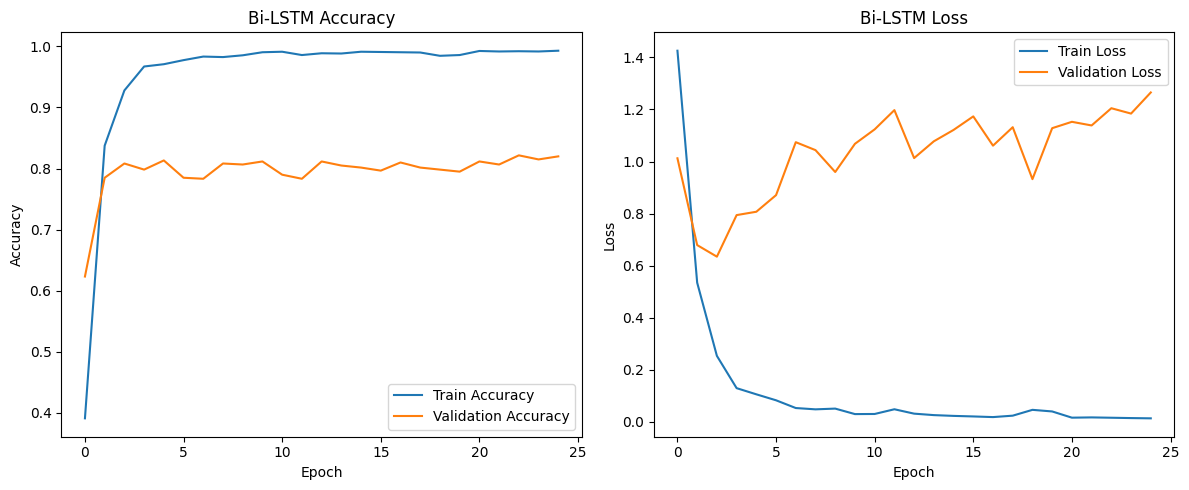

In [49]:
import matplotlib.pyplot as plt


# Plot Bi-LSTM accuracy and loss
def plot_bilstm_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Bi-LSTM Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Bi-LSTM Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Call it
plot_bilstm_history(history)

Ensemble Learning 

19/19 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step
Ensemble Accuracy: 0.82


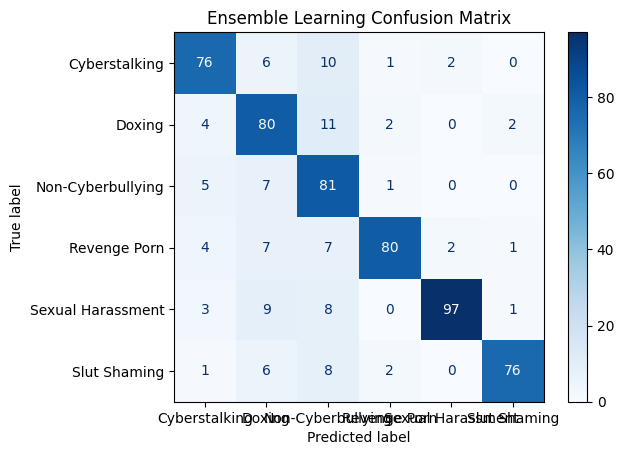

In [50]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import matplotlib.pyplot as plt


class BiLSTMClassifier(BaseEstimator, ClassifierMixin):
    """Custom wrapper for Bi-LSTM model to integrate with sklearn VotingClassifier."""

    def fit(self, X, y):
        return self  # Already trained

    def predict(self, X):
        bi_lstm_predictions = bi_lstm_model.predict(X)
        return bi_lstm_predictions.argmax(axis=1)


# Define classifiers
voting_clf = VotingClassifier(
    estimators=[
        ("svm", svm_classifier),
        ("nb", nb_classifier),
        ("logreg", logreg_classifier),
        ("bi-lstm", BiLSTMClassifier()),  # Bi-LSTM as part of ensemble
    ],
    voting="hard",
)

# Train and predict
voting_clf.fit(X_train_tfidf, y_train)
ensemble_predictions = voting_clf.predict(X_test_tfidf)

# Accuracy
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print(f"Ensemble Accuracy: {ensemble_accuracy:.2f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, ensemble_predictions)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=label_encoder.classes_
)
disp.plot(cmap="Blues")
plt.title("Ensemble Learning Confusion Matrix")
plt.show()

In [51]:
# Make sure all base models support predict_proba
svm_classifier_with_proba = SVC(kernel="linear", probability=True, random_state=42)

# Replace in voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ("svm", svm_classifier_with_proba),
        ("nb", nb_classifier),
        ("logreg", logreg_classifier),
        # Bi-LSTM doesn't support predict_proba directly, so we skip it for soft voting
    ],
    voting="soft",  # Soft voting for probabilities
)

voting_clf.fit(X_train_tfidf, y_train)
ensemble_probs = voting_clf.predict_proba(X_test_tfidf)
ensemble_preds = voting_clf.predict(X_test_tfidf)

Soft Voting Ensemble Accuracy: 0.8333


<Figure size 800x600 with 0 Axes>

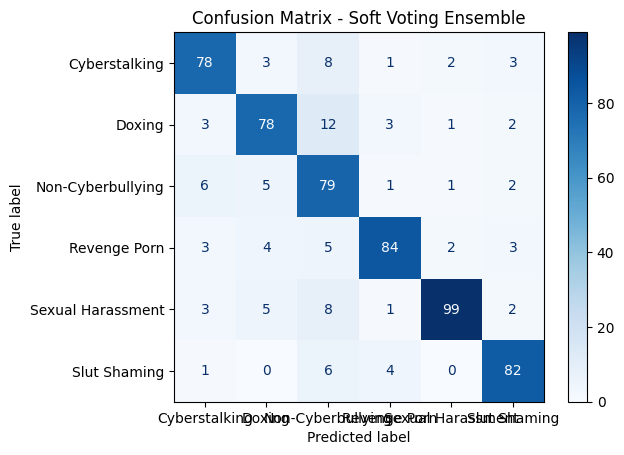

In [52]:
#Accuracy
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
print(f"Soft Voting Ensemble Accuracy: {ensemble_accuracy:.4f}")

#Confusion Matrix
cm = confusion_matrix(y_test, ensemble_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=label_encoder.classes_
)
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Soft Voting Ensemble")
plt.grid(False)
plt.show()

In [53]:
# Ensure labels are in string format for the report
target_names = list(map(str, label_encoder.classes_))

# Print the classification report
print("📊 Classification Report for Ensemble Learning Model:\n")
print(classification_report(y_test, ensemble_predictions, target_names=target_names))

📊 Classification Report for Ensemble Learning Model:

                   precision    recall  f1-score   support

    Cyberstalking       0.82      0.80      0.81        95
           Doxing       0.70      0.81      0.75        99
Non-Cyberbullying       0.65      0.86      0.74        94
     Revenge Porn       0.93      0.79      0.86       101
Sexual Harassment       0.96      0.82      0.89       118
     Slut Shaming       0.95      0.82      0.88        93

         accuracy                           0.82       600
        macro avg       0.83      0.82      0.82       600
     weighted avg       0.84      0.82      0.82       600



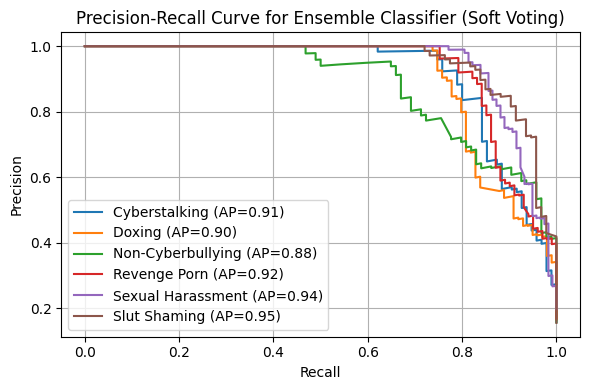

In [54]:
# Binarize true labels
y_test_bin = label_binarize(y_test, classes=voting_clf.classes_)

# Plot PR curve
plt.figure(figsize=(6, 4))

for i, class_label in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(
        y_test_bin[:, i], ensemble_probs[:, i]
    )
    avg_precision = average_precision_score(y_test_bin[:, i], ensemble_probs[:, i])
    plt.plot(recall, precision, label=f"{class_label} (AP={avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Ensemble Classifier (Soft Voting)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
print("Encoded Labels:", label_encoder.classes_)

Encoded Labels: ['Cyberstalking' 'Doxing' 'Non-Cyberbullying' 'Revenge Porn'
 'Sexual Harassment' 'Slut Shaming']


In [58]:
# Function to take user input and predict the output with label name
def predict_user_input():
    user_input = input("Enter a text for prediction: ")

    # Preprocess the input (convert text to TF-IDF features)
    input_tfidf = tfidf_vectorizer.transform([user_input])  # Transform the user input

    # Predict using the ensemble model
    prediction = voting_clf.predict(input_tfidf)

    # Convert numerical label back to original label name
    predicted_label_name = label_encoder.inverse_transform(prediction)[0]

    # Print the input and output
    print(f"\nInput text: {user_input}")
    print(f"Predicted label: {predicted_label_name}")


# Call the function
predict_user_input()


Input text: jenny is ugly
Predicted label: Doxing


In [59]:
# Assuming you named your Bi-LSTM model as bi_lstm_model
bi_lstm_model.save("model.h5")

# To load later
# from tensorflow.keras.models import load_model
# bi_lstm_model = load_model("bi_lstm_model.h5")

In [60]:
import pickle

with open("tokenizer.pickle", "wb") as f:
    pickle.dump(tokenizer, f)